# Stochastic Block Model

This notebook experiments with several algorithms for community detection in the stochastic block model.

In [58]:
import numpy as np
from numpy.random import default_rng 
from scipy import linalg
import math
import matplotlib.pyplot as plt
from matplotlib import colors

rng = default_rng()

def symmetrize(A):
    """
    Takes a square matrix, A.
    Returns the symmetric matrix obtained by reflecting the 
    lower triangle across the main diagonal.
    """
    return np.tril(A) + np.tril(A,-1).T

def blockmod(sizes,probs):
    """
    Takes a list of block sizes and a square matrix of edge probabilities.
    The length of the list should equal the number of rows and columns of the matrix.
    The matrix should be symmetric.
    
    Returns the adjacency matrix of a random sample from the block model
    defined by those parameters.
    """
    n_block = sizes.shape[0]
    blocks = [ ]                     # nested list of blocks
    for i in range(n_block):
        blocklayer = [ ]             # initialize netx layer of the list of blocks       
        for j in range(n_block):
            edge_pr = probs[i,j]
            block_size = (sizes[i],sizes[j])
            block = rng.binomial(n=1,p=edge_pr,size=block_size)
            blocklayer.append(block) # append one block to the current layer
        blocks.append(blocklayer)    # add the layer to the list of blocks
    return symmetrize(np.block(blocks))

def nullmod(sizes,probs):
    """
    Takes the same inputs as the blockmod function (see above) but outputs
    a random sample from a null model that has the same number of vertices,
    same edge density, but all pairs of vertices are equally likely to be connected.
    """
    n_vert = np.sum(sizes)
    normalized_sizes = sizes / n_vert
    density = normalized_sizes.T @ probs @ normalized_sizes
    one_block_size = np.array([n_vert])
    one_edge_prob = np.array([[density]])
    return blockmod(one_block_size,one_edge_prob)

def scramble(A):
    """
    Takes a square matrix A, and applies a random permutation to the rows and columns
    """
    d = A.shape[0]
    randperm = rng.permutation(np.eye(d))
    return randperm @ A @ randperm.T

def sidebyside(method,data):
    """
    Displays matrices side by side, as color-coded heatmaps
    """
    n = len(data)
    r = (n+1) // 2
    fig,axs = plt.subplots(r,2,tight_layout = True, squeeze = False, figsize = (10,10))
    for i in range(n):
        rownum = i // 2
        colnum = i % 2
        axs[rownum, colnum].imshow(method(data[i]))
        axs[rownum, colnum].axis('off')
    if n % 2 == 1:
        axs[-1,-1].axis('off')
    plt.show()

In [59]:
def sortp(v, invert = True):
    """
    Takes a vector, v.
    Returns the permutation matrix, P, that sorts the coordinates of v in increasing order.
    If invert = True, then sort in decreasing order instead.
    """
    d = v.shape[0]
    identity_matrix = np.eye(d)
    if invert:
        indices = np.argsort(-v)
    else:
        indices = np.argsort(v)
    return identity_matrix[indices]

def sort_matrix_with_vector(A,v, invert = True):
    """
    Reorder the rows and columns of A using the permutation matrix, P,
    that arranges the coordinates of v in descending order. If invert = False,
    then use the P that arranges the coordinates of v in ascending order instead.
    """
    P = sortp(v, invert)
    return P @ A @ P.T

def do_nothing(A):
    return A

def degreesort(A):
    v = A @ np.ones(A.shape[0])
    return sort_matrix_with_vector(A,v)

def greedysort(A):
    d = A.shape[0]
    halfd = d // 2
    g1 = np.zeros(d)
    g2 = np.zeros(d)
    g1[0] = 1
    g2[1] = 1
    for n in range(2,d):
        dotprod1 = np.dot(A[n],g1) / np.dot(g1,g1)
        dotprod2 = np.dot(A[n],g2) / np.dot(g2,g2)
        if dotprod1 == dotprod2 and np.random.rand() > 0.5:
            g1[n] = 1
        elif dotprod1 == dotprod2:
            g2[n] = 1
        elif dotprod1 > dotprod2:
            g1[n] = 1
        else:
            g2[n] = 1
    P = np.zeros((d,d))
    count = 0
    for n in range(0,d):
        if g1[n] == 1:
            P[count,n] = 1
            count = count + 1
    for n in range(0,d):
        if g2[n] == 1:
            P[count,n] = 1
            count = count + 1
    return P @ A @ P.T

# Planted dense subgraph

In this model there is a baseline edge probability and an incremental probability.
Every pair of vertices are connected with at least the baseline probability.
However, if both vertices belong to the planted dense subgraph, the probability of connecting them is increased.

Two random graphs are sampled: graph B has the planted dense subgraph, graph A is a null model with equivalent edge density, but with all connection probabilities equal.

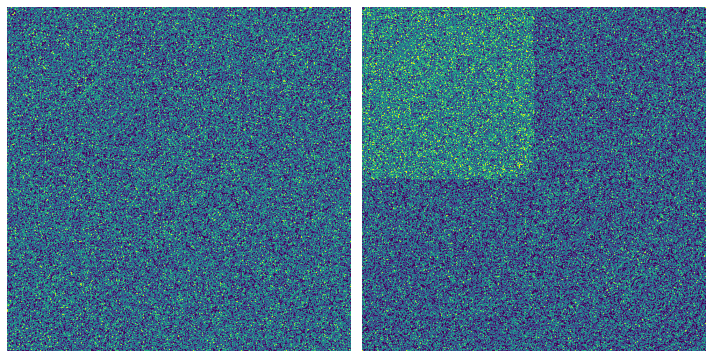

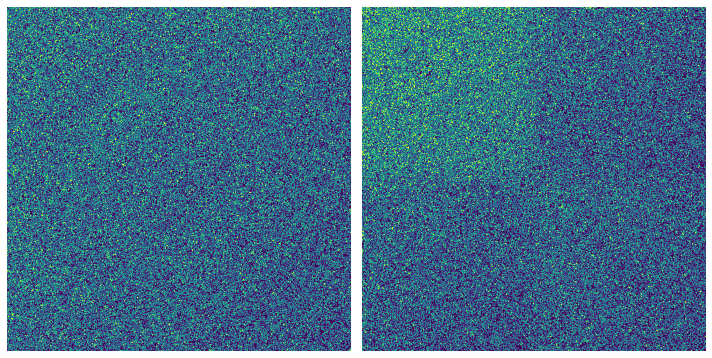

In [60]:
n_vert = 640
baseline_pr = 0.3
incr_pr = 0.15
denser_pr = baseline_pr + incr_pr
block_probs = np.array([[denser_pr,baseline_pr],[baseline_pr,baseline_pr]])
block_sizes = np.array([n_vert // 2, n_vert - n_vert // 2])

Agraph = nullmod(block_sizes,block_probs)
Bgraph = blockmod(block_sizes,block_probs)
Sgraph = scramble(Bgraph)
sidebyside(do_nothing, [Agraph,Bgraph])
sidebyside(degreesort, [Agraph,Sgraph])

# Balanced Stochastic Block Model

This model similar to the previous one except that the vertices are partitioned into two equal-sized groups and the edge formation probability is increased for *all* intra-group edges.

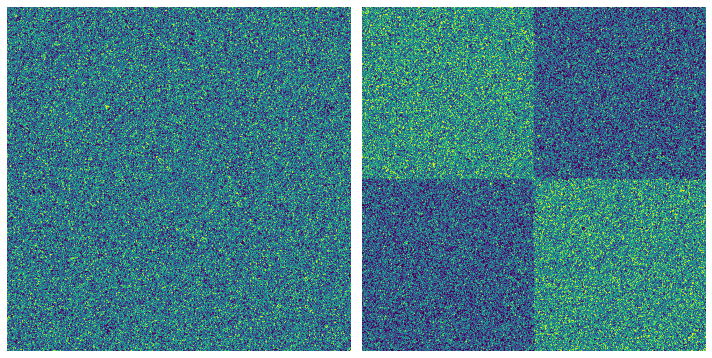

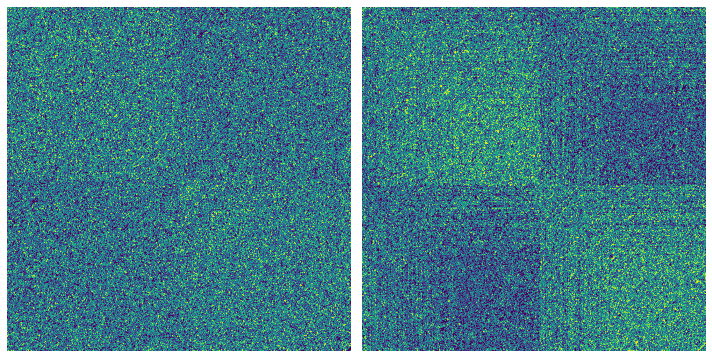

In [61]:
n_vert = 640
baseline_pr = 0.3
incr_pr = 0.2
denser_pr = baseline_pr + incr_pr
block_probs = np.array([[denser_pr,baseline_pr],[baseline_pr,denser_pr]])
block_sizes = np.array([n_vert // 2, n_vert - n_vert // 2])


Agraph = nullmod(block_sizes,block_probs)
Bgraph = blockmod(block_sizes,block_probs)
Sgraph = scramble(Bgraph)
sidebyside(do_nothing, [Agraph,Bgraph])
sidebyside(greedysort, [Agraph,Sgraph])

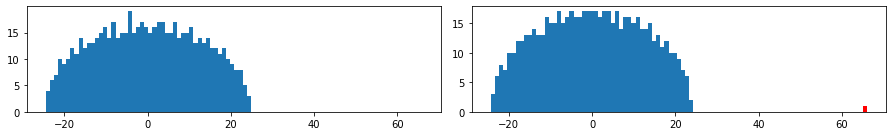

In [62]:
def zerosum(A):
    """
    Modify a matrix, A, by subtracting a constant from each entry
    to make the sum of all entries equal to 0.
    """
    d = A.shape[0]
    averager = np.ones((d,d)) / d
    return A - (averager @ A @ averager)

# Plot eigenvalue distribution of Agraph and Bgraph as side-by-side histograms.
evA = linalg.eigvalsh(zerosum(Agraph))
evB = linalg.eigvalsh(zerosum(Bgraph))
fig, (axs1,axs2) = plt.subplots(1,2,tight_layout = True,sharex = True,sharey = False,figsize=(12.5,2.))
n_binsA = math.ceil(evA[-1] - evA[0])
n_binsB = math.ceil(evB[-1] - evB[0])
axs1.hist(evA,n_binsA)
N,bins,patches=axs2.hist(evB,n_binsB)
patches[-1].set_facecolor('red')
plt.show()

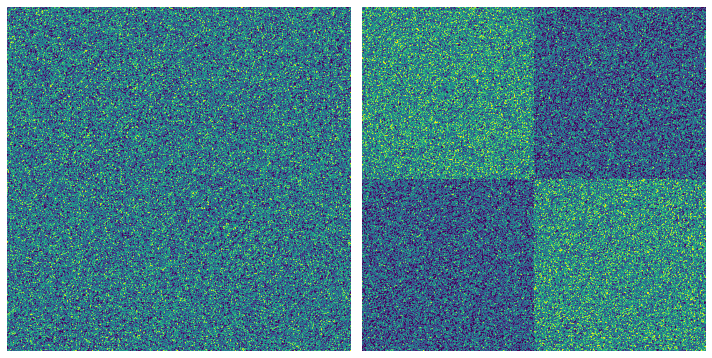

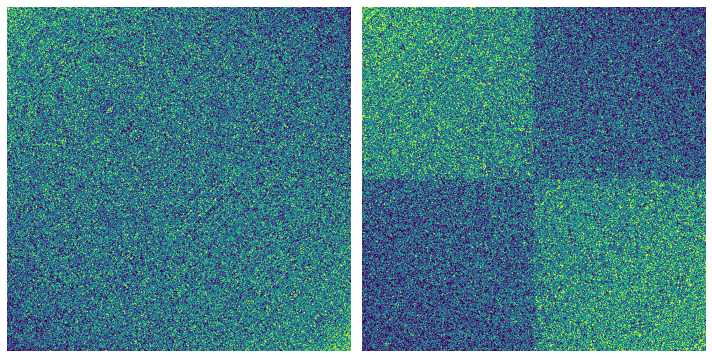

In [63]:
def eigsort(A):
    ev, em = linalg.eigh(zerosum(A))
    v = np.transpose(em)[-1]
    return sort_matrix_with_vector(A,v)

Agraph = nullmod(block_sizes,block_probs)
Bgraph = blockmod(block_sizes,block_probs)
Sgraph = scramble(Bgraph)
sidebyside(do_nothing, [Agraph,Bgraph])
sidebyside(eigsort, [Agraph,Sgraph])